# **Reducing APF Data Tutorial**
By Zoe Ko

## About this tutorial

This tutorial is intended to show the progression of APF 1D data products. Begin with the reduced 1D spectra and follow four steps to reduce the data:
* Deblaze and normalize the data by dividing out the echelle blaze function
* Transform the wavelength solution of the data to constant RV space
* Download a corresponding synthetic or empirical spectrum and transform its wavelength solution to constant RV space
* Run a chi-squared test on the data and the empirical spectrum to determine doppler shift
* Shift the data to be in the rest frame


## About the data

The APF data can be downloaded from the Breakthrough Listen database, which can be found through the [Breakthrough Listen webpage](https://seti.berkeley.edu/listen/data.html). The solar flux spectrum can be found from [NSO](https://drive.google.com/file/d/12ByZSN1k6MOXBqOO-6Dpqrp1HvHr8b6z/view?usp=sharing).

In [407]:
from astropy.io import fits
import matplotlib.pylab as plt
import numpy as np
import scipy
from scipy.interpolate import interp1d
from scipy.interpolate import splev, splrep

## Read in APF Data

This tutorial uses 10 CVn (HIP62207), an F type star. It takes spectra from order 38, which includes wavlengths from approximately 5380 to 5460 Angstroms.

In [408]:
star = 'HIP62207'
APF_wavelength_path = '/mnt_home/zoek/code/APF-BL-DAP/APFTutorial/apf_wav.fits'
APF_flux_path = '/datag/blpd0/datax/apf/rarj.224.fits'

wl_file = fits.open(APF_wavelength_path)
fl_file = fits.open(APF_flux_path)
wl_image = wl_file[0].data
fl_image = fl_file[0].data

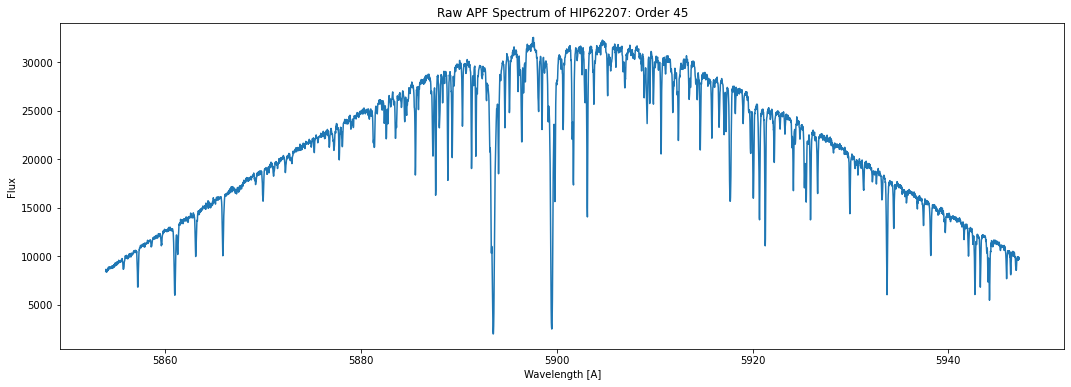

In [588]:
plt.rcParams["figure.figsize"] = (18,6)

order = 45
wl = wl_image[order]
flux = fl_image[order][:-1]
plt.plot(wl,flux)

plt.title('Raw APF Spectrum of ' + star + ': Order ' + str(order))
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.show()

## Dividing out the Echelle Blaze Function

Divide the data into bins of 100 pixels. Find the flux value in the 95th percentile within each bin and plot these flux values onto the wavelength values. Divide the APF flux spectrum by the fit of the 95th percentile flux values.

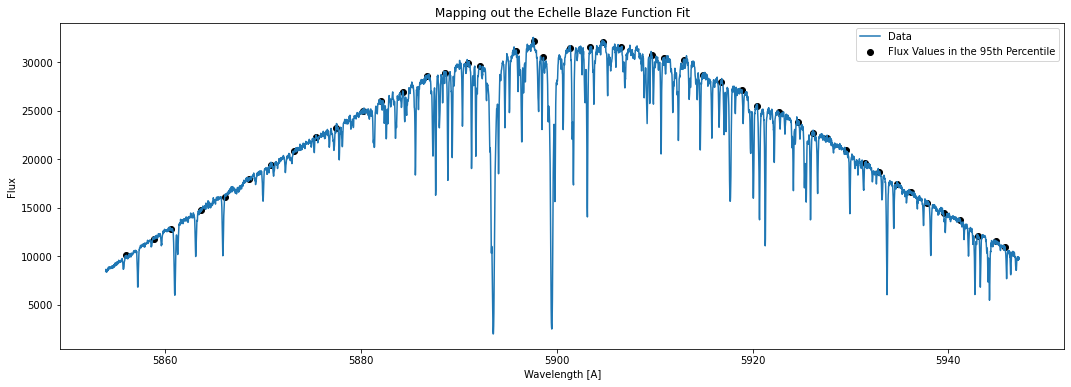

In [574]:
bin = 100

# this list will contain the indices corresponding to each of the 95th percentile flux values in each bin
indices = []

for i in np.arange((len(wl) - (bin)), step = bin):
    flux_values = []
    for j in np.arange(i, i + bin, step = 1):
        value = flux[j]
        flux_values = np.append(flux_values, value)
    # find the 95th percentile flux value: we use 95 to get the maximum flux value in general 
    # but avoid issues with cosmic rays and other emission lines
    flux_in_bin = np.percentile(flux_values, 95)
    # find the closest value in the flux array to the 95th percentile value
    absolute_difference_function = lambda list_value : abs(list_value - flux_in_bin)
    flux_in_bin = min(flux_values.tolist(), key=absolute_difference_function)
    index_in_bin = flux_values.tolist().index(flux_in_bin)
    index = i + index_in_bin
    indices = np.append(indices, index)

# these lists will contain the wavlength and flux values at each index in 'indices'
wl_values = []
fl_values = []

for index in indices:
    ind = int(index)
    wl_values = np.append(wl_values, wl[ind])
    fl_values = np.append(fl_values, flux[ind])
    
plt.plot(wl, flux, label = 'Data')
plt.scatter(wl_values, fl_values, color = 'black', label = 'Flux Values in the 95th Percentile')
plt.title('Mapping out the Echelle Blaze Function Fit')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.legend()
plt.show()

Plot fl_values onto wl_values so that the length of the arrays match that of the APF spectrum. Set s to 500000 to smooth the fit.

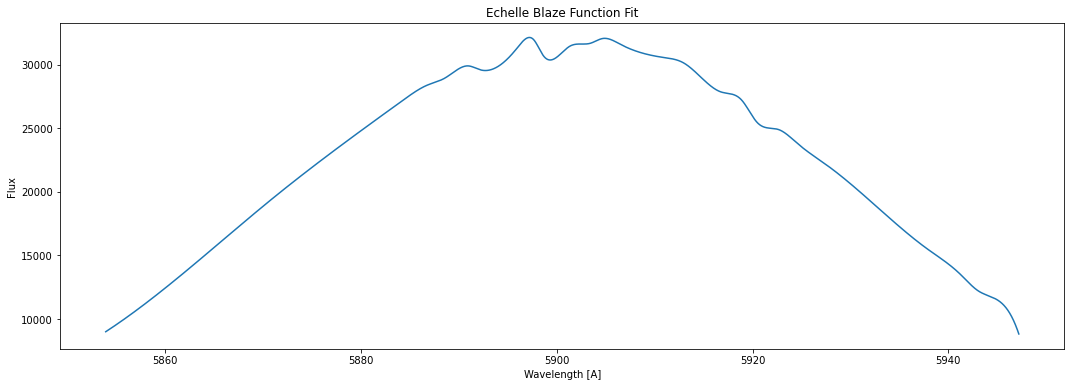

In [575]:
spl = splrep(wl_values, fl_values, s = 500000)
flux_fit = splev(wl, spl)
plt.plot(wl, flux_fit)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Echelle Blaze Function Fit')
plt.show()

Divide out the fit from the data.

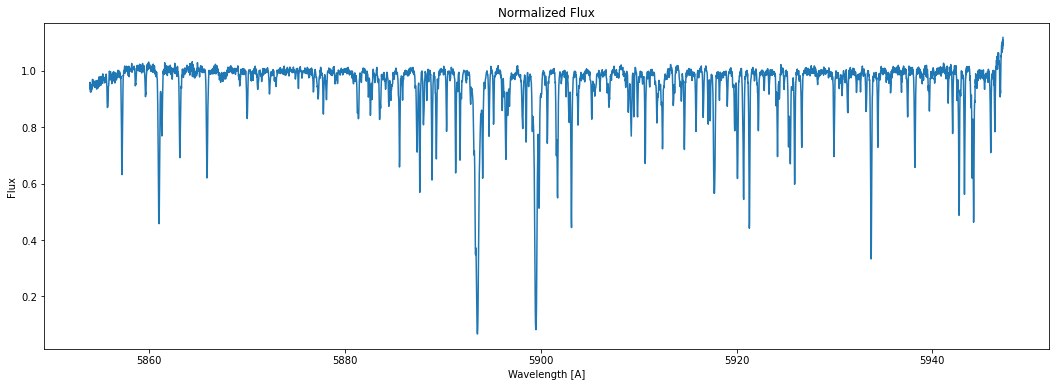

In [576]:
first_normalized_flux = flux / flux_fit
plt.plot(wl, first_normalized_flux)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Normalized Flux')
plt.show()

However, this spectra is not well normalized because the values in each bin were drawn from the 95th percentile. Do another normalization by finding the 98th percentile of the data and dividing the data by that value to ensure that the continuum is at 1.0.

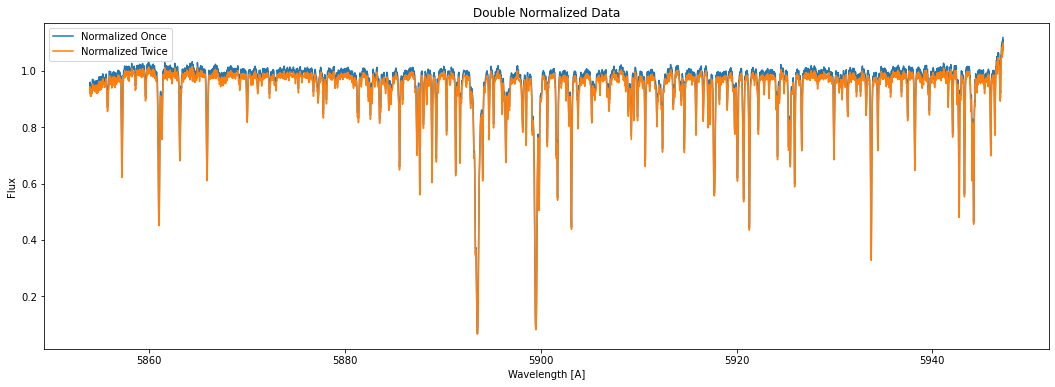

In [577]:
flux98 = np.percentile(first_normalized_flux, 98)
flux = first_normalized_flux / flux98

plt.plot(wl, first_normalized_flux, label = 'Normalized Once')
plt.plot(wl, flux, label = 'Normalized Twice')
plt.legend()
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Double Normalized Data')
plt.show()

Now we have a normalized spectrum with its continuum at 1.0.

## Empirical Solar Spectrum
Read the empirical solar spectrum using astropy.io.fits. There are two arrays: one is the wavelength from around 3000 angstroms to 12,500 Angstroms, and the second is the corresponding flux array. Truncate it to match the wavelength range of the APF data. 

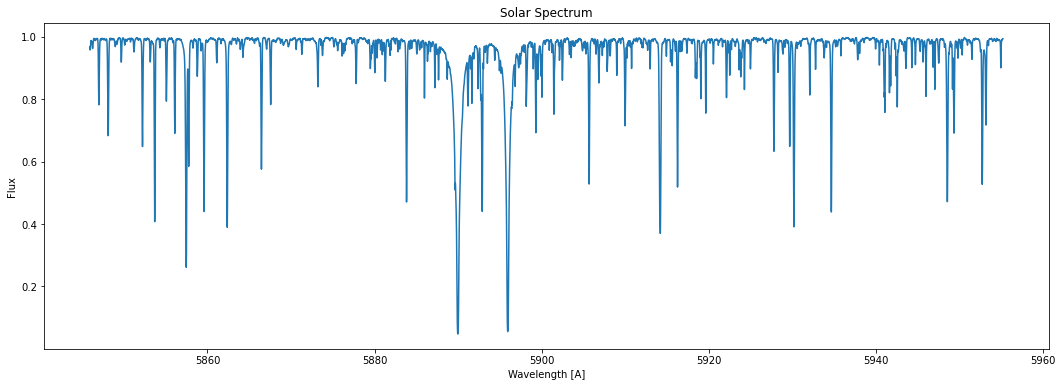

In [578]:
solar_spectrum_path = '/mnt_home/zoek/code/APF-BL-DAP/APFTutorial/nso.fits'

solar_spectrum = fits.open(solar_spectrum_path)
wl_temp = solar_spectrum[0].data
fl_temp = solar_spectrum[1].data

# wavelengths of APF data
min_wl = min(wl) - 8
absolute_difference_function = lambda list_value : abs(list_value - min_wl)
w = min(wl_temp.tolist(), key = absolute_difference_function)
min_index = wl_temp.tolist().index(w)

max_wl = max(wl) + 8
absolute_difference_function = lambda list_value : abs(list_value - max_wl)
w = min(wl_temp.tolist(), key = absolute_difference_function)
max_index = wl_temp.tolist().index(w)

wl_syn = wl_temp[min_index:max_index]
fl_syn = fl_temp[min_index:max_index]

plt.plot(wl_syn, fl_syn)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Solar Spectrum')
plt.show()

## Finding the velocity shift of the data from the empirical spectrum

To find the velocity shift of the data, run a chi-squared test on the data and the empirical spectrum shifted at different velocities. A chi-squared test measures how well data matches a model. Run the test over a range of velocity values to see which velocity value minimizes chi-squared, indicating best fit. The function 'chi' calculates the chi-squared value of two arrays. 

For each velocity value, shift each pixel accordingly by the Doppler equation; this won't be a constant shift for every pixel since the Doppler equation depends on wavelength. 'model' transforms the empirical spectrum into a velocity shifted spectrum truncated to match the length of the APF spectrum. 

Finally, 'shift_APF' shifts the APF spectrum by the given velocity to shift the spectrum into rest frame.

In [579]:
C = 299792.458 #in km/s

def chi(model, data):
    '''given two arrays of the same length, calculate chi-squared'''
    return np.sum((data - model) ** 2)

def model(velocity, wl_syn, fl_syn_norm, wl_APF):
    '''given a velocity shift, return corresponding shifted wavelength array, plot shifted wl_syn onto fl_syn, and
    interpolate onto wl_APF to match the length of the APF spectrum'''
    shifted_wl_syn = wl_syn[50:(len(wl_syn)-50)] - (wl_syn[50:(len(wl_syn)-50)] * velocity / C)
    dopshift_func = interp1d(shifted_wl_syn, fl_syn_norm[50:(len(wl_syn)-50)], kind = 'cubic')
    return dopshift_func(wl_APF)

def shift_APF(velocity, wl):
    '''given a velocity shift, return corresponding
    shifted APF wavelength array'''
    shifted_wl = wl[50:(len(wl)-50)] + (wl[50:(len(wl)-50)] * velocity / C)
    return shifted_wl

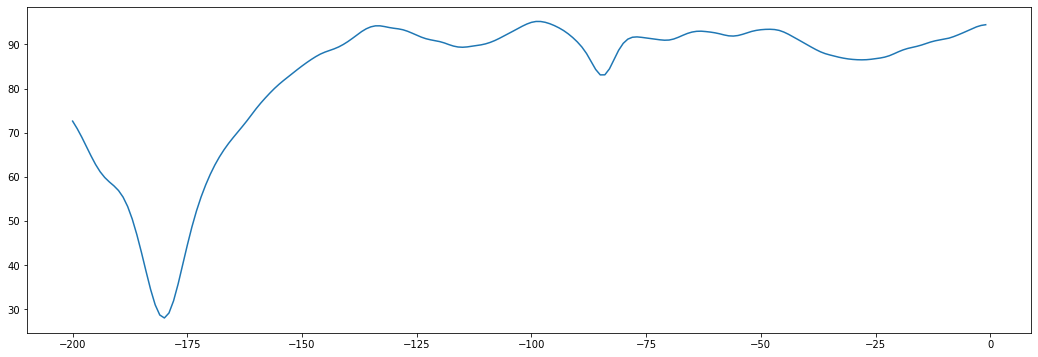

The APF spectrum needs to be shifted by -180 km/s.


In [580]:
vel_min = -200
vel_max = 0
vel_spacing = 1

# plot up chi squared values for different velocities
vel_values = np.arange(vel_min, vel_max, vel_spacing)
chi_squared_values = []

for vel in vel_values:
    chi_squared = chi(model(vel, wl_syn, fl_syn, wl), flux)
    chi_squared_values = np.append(chi_squared_values, chi_squared)

# find the velocity shift corresponding to the miminum chi squared value
min_chi = np.amin(chi_squared_values)
vel_shift = vel_values[chi_squared_values.tolist().index(min_chi)]

plt.plot(np.arange(vel_min, vel_max), chi_squared_values)
plt.show()

print('The APF spectrum needs to be shifted by ' + str(vel_shift) + ' km/s.')

The minimum chi-squared value occurs where the residual between the data and the empirical spectrum is minimized, indicating a best fit. The noise around this minimum represent RV values where the data happens to fit better or worse with the empirical spectrum.

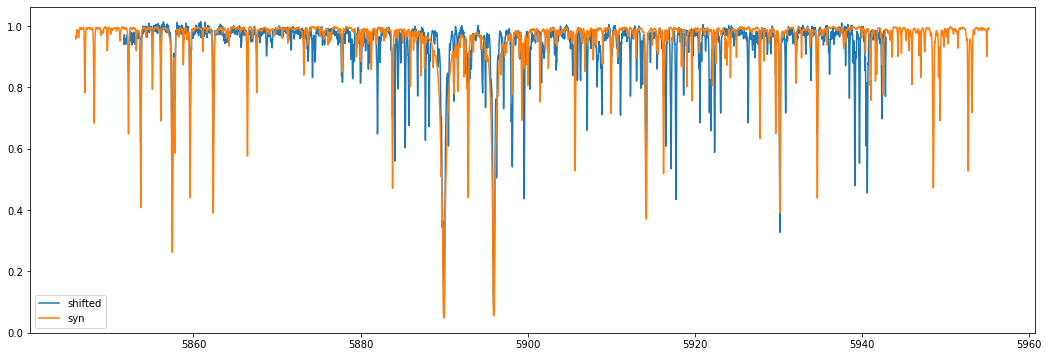

In [581]:
# shift the APF spectrum by vel_shift
shifted_wl = shift_APF(vel_shift, wl)
shifted_fl = flux[50:(len(wl)-50)]

# plt.plot(wl, flux, label = 'unshifted')
plt.plot(shifted_wl, shifted_fl, label = 'shifted')
plt.plot(wl_syn, fl_syn, label = 'syn')
plt.legend()
plt.show()

Make a plot of the unshifted APF spectrum against the empirical spectrum.

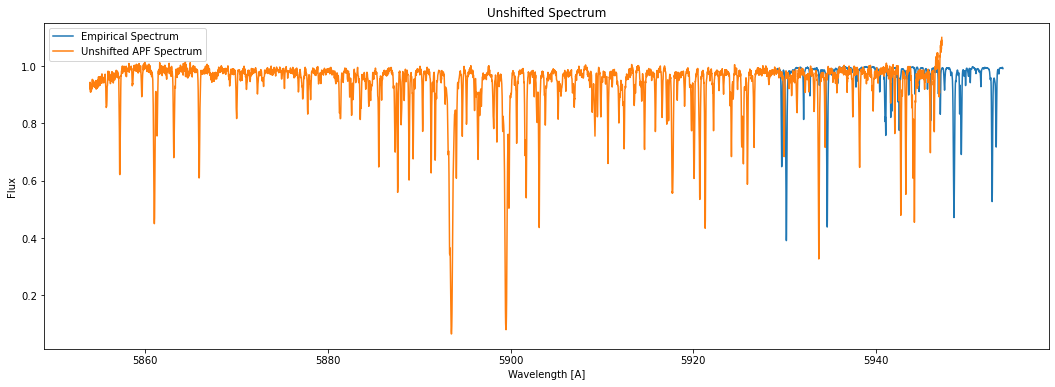

In [582]:
plt.plot(wl_syn_temp, fl_syn_temp, label = 'Empirical Spectrum')
plt.plot(wl, flux, label = 'Unshifted APF Spectrum')

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Unshifted Spectrum')
plt.legend()
plt.show()

Zoom in to a smaller region of the plot to better visualize the offset between the data and the empirical spectrum.

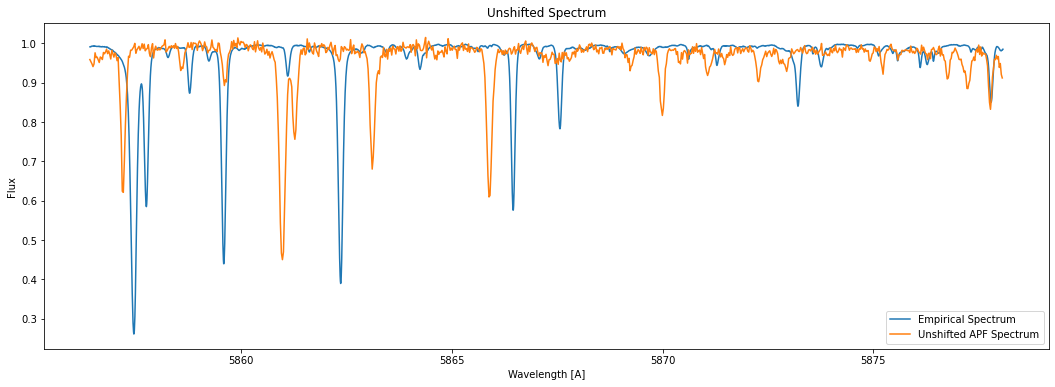

In [583]:
min_apf = 100
max_apf = 1000


# wavelengths of APF data
min_wl = wl[min_apf]
absolute_difference_function = lambda list_value : abs(list_value - min_wl)
w = min(wl_syn.tolist(), key = absolute_difference_function)
min_index = wl_syn.tolist().index(w)

max_wl = wl[max_apf]
absolute_difference_function = lambda list_value : abs(list_value - max_wl)
w = min(wl_syn.tolist(), key = absolute_difference_function)
max_index = wl_syn.tolist().index(w)

wl_syn_temp = wl_syn[min_index:max_index]
fl_syn_temp = fl_syn[min_index:max_index]


plt.plot(wl_syn_temp, fl_syn_temp, label = 'Empirical Spectrum')
plt.plot(wl[100:1000], flux[100:1000], label = 'Unshifted APF Spectrum')

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Unshifted Spectrum')
plt.legend()
plt.show()

Plot the residuals.

In [584]:
# # wavelengths of APF data
# min_wl = min(wl)
# absolute_difference_function = lambda list_value : abs(list_value - min_wl)
# w = min(wl_syn.tolist(), key = absolute_difference_function)
# min_index = wl_syn.tolist().index(w)

# max_wl = max(wl)
# absolute_difference_function = lambda list_value : abs(list_value - max_wl)
# w = min(wl_syn.tolist(), key = absolute_difference_function)
# max_index = wl_syn.tolist().index(w)

# wl_syn_temp = wl_syn[min_index:max_index]
# fl_syn_temp = fl_syn[min_index:max_index]


# plt.plot(wl_syn_temp, fl_syn_temp, label = 'Empirical Spectrum')
# plt.plot(wl, flux, label = 'Unshifted APF Spectrum')

# plt.xlabel('Wavelength [A]')
# plt.ylabel('Flux')
# plt.title('Unshifted Spectrum')
# plt.legend()
# plt.show()


# residuals_unshifted = flux[len(wl_syn_temp)] - fl_syn_temp
# plt.plot(wl_syn, residuals_unshifted)
 
# plt.xlabel('Wavelength [A]')
# plt.ylabel('Flux')
# plt.title('Residuals of Shifted APF Spectrum against Empirical Spectrum')
# plt.show()

# print('The average residual is ' + str(np.average(residuals_unshifted)))

Now make a plot of the shifted APF spectrum against the empirical spectrum. The data should line up with the empirical spectrum much better.

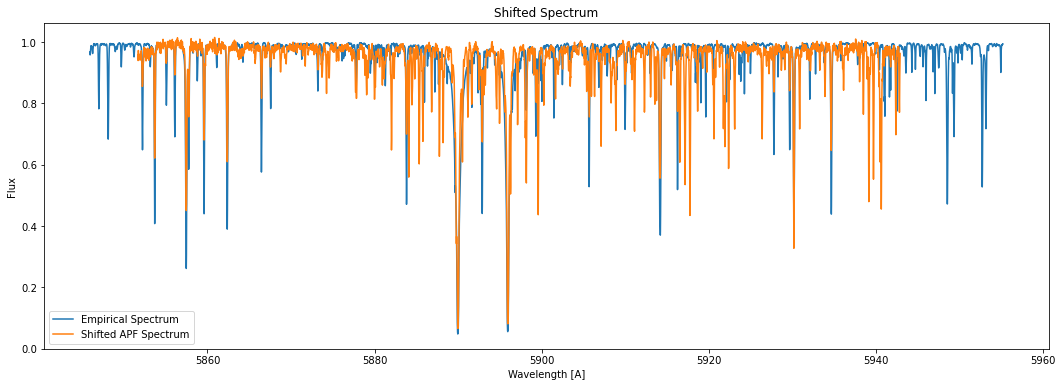

In [585]:
plt.plot(wl_syn, fl_syn, label = 'Empirical Spectrum')
plt.plot(shifted_wl, shifted_fl, label = 'Shifted APF Spectrum')

plt.title('Shifted Spectrum')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.legend()
plt.show()

Zoom in to a smaller region of the plot to better visualize the difference.

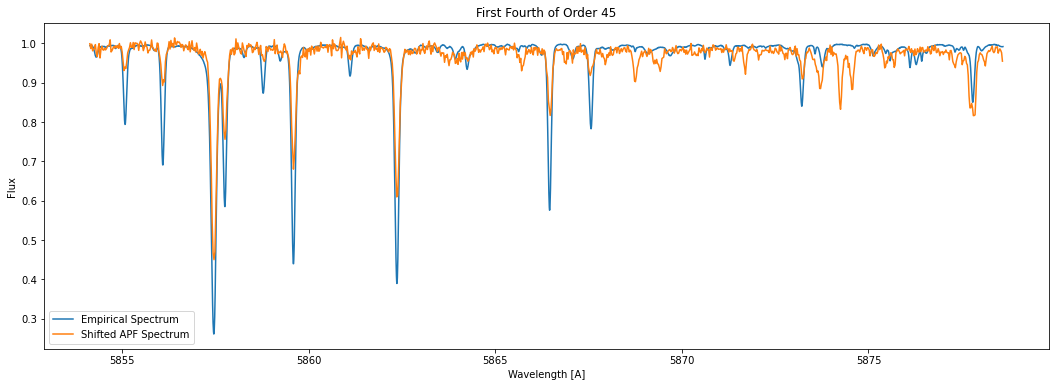

In [586]:
min_apf =  100
max_apf = int(len(shifted_wl) / 4)

# min_apf = len(shifted_wl) - int(len(shifted_wl) / 4)
# max_apf = len(shifted_wl) - 1

# min_apf = int(len(shifted_wl) / 2) - 500
# max_apf = int(len(shifted_wl) / 2) + 500


# wavelengths of APF data
min_wl = shifted_wl[min_apf]
absolute_difference_function = lambda list_value : abs(list_value - min_wl)
w = min(wl_syn.tolist(), key = absolute_difference_function)
min_index = wl_syn.tolist().index(w)

max_wl = shifted_wl[max_apf]
absolute_difference_function = lambda list_value : abs(list_value - max_wl)
w = min(wl_syn.tolist(), key = absolute_difference_function)
max_index = wl_syn.tolist().index(w)

wl_syn_temp = wl_syn[min_index:max_index]
fl_syn_temp = fl_syn[min_index:max_index]


plt.plot(wl_syn_temp, fl_syn_temp, label = 'Empirical Spectrum')
plt.plot(shifted_wl[min_apf:max_apf], shifted_fl[min_apf:max_apf], label = 'Shifted APF Spectrum')

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
# plt.ylim(-0.3, 4)
# plt.title('Shifted Spectrum')
plt.title('First Fourth of Order ' + str(order))
plt.legend()
plt.show()


The residuals should be much lower.

In [571]:
# residuals_shifted = shifted_fl - fl_syn[:len(shifted_wl)]
# plt.plot(wl_syn[:len(shifted_wl)], residuals_shifted)

# plt.title('Residuals of Shifted APF Spectrum against Empirical Spectrum')
# plt.xlabel('Wavelength [A]')
# plt.ylabel('Flux')
# plt.show()

## Final Product
Now we have a normalized, deblazed APF spectrum, shifted so that it is in its rest frame.

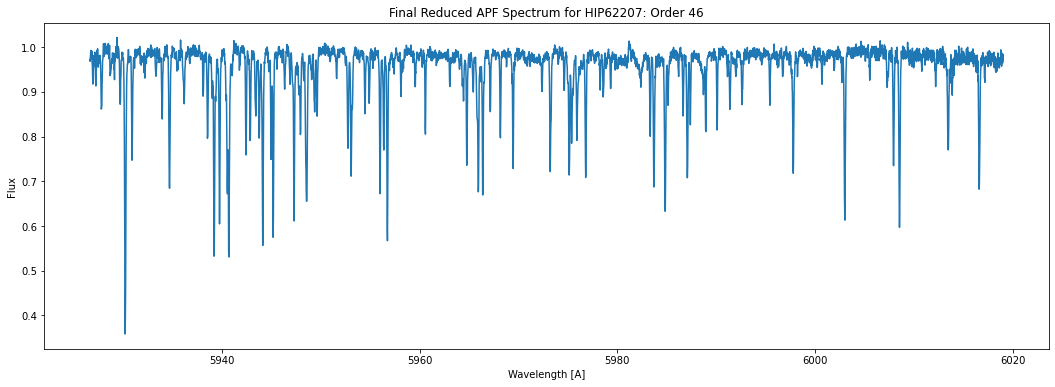

In [572]:
plt.plot(shifted_wl, shifted_fl)
plt.title('Final Reduced APF Spectrum for ' + star + ': Order ' + str(order))
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.show()